# Career Recommendation
--- 
What is Recommendation ?

Recommendation systems are  ML system, which help in getting relevent information or suggestion

- There are two Type

**1. Content-Based**|

**2. Collaborative Filtering**



## ***Import libraries***

In [42]:
import os
import datetime
import math
import random
import warnings
import re

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from datetime import datetime
import networkx as nx

import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk 

import spacy
nlp=spacy.load('en')
nlp.remove_pipe('parser')
nlp.remove_pipe('ner')
# nlp.remove_pipe('tagger')

from wordcloud import WordCloud, STOPWORDS

import gensim
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

#import plotly.offline as py
#py.init_notebook_mode(connected=True)

In [43]:
input_dir = '../input' 
for f in  os.listdir(input_dir):
    print(f)

emails.csv
questions.csv
professionals.csv
comments.csv
tag_users.csv
group_memberships.csv
tags.csv
answer_scores.csv
students.csv
groups.csv
tag_questions.csv
question_scores.csv
matches.csv
answers.csv
school_memberships.csv


## ***Load dataset***

In [44]:
df_professionals = pd.read_csv("../input/professionals.csv",)
df_groups = pd.read_csv("../input/groups.csv")
df_comments = pd.read_csv("../input/comments.csv")
df_school_memberships = pd.read_csv("../input/school_memberships.csv")
df_tags = pd.read_csv("../input/tags.csv")
df_emails = pd.read_csv("../input/emails.csv")
df_group_memberships = pd.read_csv("../input/group_memberships.csv")
df_answers = pd.read_csv("../input/answers.csv")
df_answers_scores=pd.read_csv("../input/answer_scores.csv")
df_students = pd.read_csv("../input/students.csv")#,index_col = "students_id", parse_dates = ['students_date_joined'])
df_matches = pd.read_csv("../input/matches.csv")
df_questions = pd.read_csv("../input/questions.csv")
df_questions_score = pd.read_csv("../input/question_scores.csv")

df_tag_users = pd.read_csv("../input/tag_users.csv")
df_tag_questions = pd.read_csv("../input/tag_questions.csv")

### Global Parameters 


In [45]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth',-1)

SEED=2019
random.seed(SEED)
np.random.seed(SEED)

## Feature Extraction

##### Parameters
The *token_pos * is used in spacy to extract only words belonging to the *part-of-speech (POS)* tagging. With this we want to reduce the text to only relevant words. A description of all available POS tags can be read at https://spacy.io/api/annotation#pos-tagging

The actual_date should simulate the current date, because we only have data until 2019-01-31 end of the day.

In [46]:
# Spacy Tokenfilter for part-of-speech tagging
token_pos = ['NOUN', 'VERB', 'PROPN', 'ADJ', 'INTJ', 'X']

# The data export was from 1. February 2019. For Production use datetime.now()
actual_date = datetime(2019, 2 ,1)

In [47]:
def nlp_preporocessing(data):
    """Use NLP to transform the text corpus to cleaned sentences and word tokens

        param data: List with sentences, which should be processed.
        return processed_tokens: List with the cleaned and tokenized sentences
    """
    def token_filter(token):
        """ Keep tokens who are alphabatic, in the POS(Part-Of-Speach) list and not in stop list"""
        return not token.is_stop and token.is_alpha and token.pos_ in token_pos
    
    data = [re.compile(r'<[^>]+>').sub('', x) for x in data] #Remove HTML-tags    
    processed_tokens=[]
    data_pipe=nlp.pipe(data)
    for doc in data_pipe:
        filtered_tokens=[token.lemma_.lower() for token in doc if token_filter(token)]
        processed_tokens.append(filtered_tokens)
    return processed_tokens
    

### Features

#### For working with time delta, we will first of all transform the datetime columns (date_added and date_joined). After this we will create the following new features. 

* **Questions Dataframe**
    * **Questions_full_text** : Merge the questions title with with the body for later use for NLP
    * **Questions_answers_count** : Number of answer a questions has.
    * **Questions_first_answers** : Timestamp of first answer on questions.
    * **Questions_last_answers** : Timestamp of last answer on questions.
    * **questions_hearts:** Hearts score for the question.
    * **questions_tags: :** List with tags for the questioN
    * **nlp_tokens** : Extract relevent tokens from the questions full text.

* **Aaswer Dataframe**
    * **time_delta_answer** : Time delta from questions to answer.
    * **answers_time_rank:** Ranking for time to answer the question.
    * **answers_hearts:** Hearts score for the answer.
    
* **Professional Dataframe**
    * **Professional_time_delta_joined** : Time since Professional creating the Account
    * **Professional_answers_count** : Number of written answers.
    * **Professional_comments_count** : Number of written comments.
    * **date_first_answer** : Date first answer.
    * **date_last_answer** : Date last answer. 
    * **date_first_comment**: Date first comment.
    * **date_last_comment**: Date last comment.
    * **date_last_activity**: Date last activity (answer or comment).
    * **date_first_activity**: Date first activity (answer or comment).
    * **Professional_answers_hearts** : Hearts scores for all answers.
    * **Professional_tags** : List with tags for the professionals.
   
* **Questions Dataframe**
    * **students_time_delta_joined**: Time since creating the account.
    * **students_questions_count**: Number of written questions.
    * **students_comments_count**: Number of written comments.
    * **date_last_questions**: Date last question.
    * **date_first_questions**: Date first question.
    * **date_last_comment**: Date last comment.
    * **date_first_comment**: Date first comment.
    * **date_last_activity**: Date last activity (question or comment).
    * **date_first_activity**: Date first activity (question or comment).
    * **students_questions_hearts:** Hearts score for all questions.
    * **students_tags:** List with tags for the students. 
   
   
* **new DataFrame emails_response**:
   - Has the response activity from professionals to emails and additional informations about the questions behind.
    * **time_delta_email_answer**: Time needed the question was answered after the email was send.
    * **time_delta_question_email**: Time needed the email was send after the questions was written.
    

In [48]:
# Transform datetime datatypes
df_questions.questions_date_added=pd.to_datetime(df_questions.questions_date_added, infer_datetime_format=True)
df_answers.answers_date_added=pd.to_datetime(df_answers.answers_date_added, infer_datetime_format=True)
df_professionals.professionals_date_joined=pd.to_datetime(df_professionals.professionals_date_joined, infer_datetime_format=True)
df_students.students_date_joined=pd.to_datetime(df_students.students_date_joined, infer_datetime_format=True)
df_emails.emails_date_sent=pd.to_datetime(df_emails.emails_date_sent, infer_datetime_format=True)
df_comments.comments_date_added=pd.to_datetime(df_comments.comments_date_added, infer_datetime_format=True)

In [49]:
df_emails.dtypes

emails_id                 int64         
emails_recipient_id       object        
emails_date_sent          datetime64[ns]
emails_frequency_level    object        
dtype: object

>## Questions

In [50]:
# Merge Question Title and Body for creating full text
df_questions['questions_full_text'] = df_questions['questions_title'] +'\r\n\r\n'+ df_questions['questions_body']

# Count of answers
df_temp = df_answers.groupby(df_answers.answers_question_id).size()
df_questions['questions_answers_count'] = pd.merge(df_questions, pd.DataFrame(df_temp.rename('count')), left_on='questions_id', right_index=True, how='left')['count'].fillna(0).astype(int)

# First answer for questions
df_temp = df_answers[['answers_question_id', 'answers_date_added']].groupby('answers_question_id').min()

df_questions['questions_first_answers'] = pd.merge(df_questions, pd.DataFrame(df_temp), left_on='questions_id', right_index=True, how='left')['answers_date_added']

# Last answer fo any questions
df_temp = df_answers[['answers_question_id', 'answers_date_added']].groupby('answers_question_id').max()
df_questions['questions_last_answers'] = pd.merge(df_questions, pd.DataFrame(df_temp), left_on='questions_id', right_index=True, how='left')['answers_date_added']

# Hearts score of questions
df_temp=pd.merge(df_questions, df_questions_score,left_on='questions_id', right_on='id',how='left')
df_questions['questions_hearts']=df_temp['score'].fillna(0).astype(int)

# # Questions Tags list
df_temp=pd.merge(df_questions, df_tag_questions, left_on='questions_id', right_on='tag_questions_question_id', how='inner')
df_temp=pd.merge(df_temp, df_tags,left_on='tag_questions_tag_id', right_on='tags_tag_id', how='inner')
df_temp=(df_temp.groupby('questions_id')['tags_tag_name'].apply(list).rename('questions_tags')).to_frame()

df_questions['questions_tags']=pd.merge(df_questions,df_temp, left_on='questions_id', right_index=True, how='left')['questions_tags']

# Get NLP Token
df_questions['nlp_tokens'] = nlp_preporocessing(df_questions['questions_full_text'])


In [51]:
### Answers
# Days required to answer the question
df_temp = pd.merge(df_questions, df_answers, left_on='questions_id', right_on='answers_question_id')
df_answers['time_delta_answer'] = (df_temp.answers_date_added - df_temp.questions_date_added) 

# Ranking for answers time
df_answers['answer_time_rank']=df_answers.groupby('answers_question_id')['time_delta_answer'].rank(method='min').astype(int)

# Hearts Score
df_temp = pd.merge(df_answers, df_answers_scores, left_on='answers_id', right_on='id', how='left')
df_answers['answers_hearts'] = df_temp['score'].fillna(0).astype(int)

> ###  Professionals

In [52]:
# Time since Professional Join the Careervillage
df_professionals['professionals_time_delta_joined']=actual_date-df_professionals.professionals_date_joined

# Number of answers given by professional
df_temp=df_answers.groupby('answers_author_id').size()
df_professionals['professionals_answers_count']=pd.merge(df_professionals, pd.DataFrame(df_temp.rename('count')),left_on='professionals_id',right_index=True, how='left')['count'].fillna(0).astype(int)

#Number of comments given by professional
df_temp=df_comments.groupby('comments_author_id').size()
df_professionals['professionals_comments_count']=pd.merge(df_professionals, pd.DataFrame(df_temp.rename('count')),left_on='professionals_id',right_index=True, how='left')['count'].fillna(0).astype(int)

# Last activity (Answer)
df_temp=pd.DataFrame(df_answers.groupby('answers_author_id')['answers_date_added'].max().rename('last_answer'))
df_professionals['date_last_answer']=pd.merge(df_professionals, df_temp, left_on='professionals_id', right_index=True, how='left')['last_answer'] 

# First Activity (Answer)
df_temp=pd.DataFrame(df_answers.groupby('answers_author_id')['answers_date_added'].min().rename('first_answer'))
df_professionals['date_first_answer']=pd.merge(df_professionals, df_temp, left_on='professionals_id', right_index=True, how='left')['first_answer']

# Last Comment Activity
df_temp=pd.DataFrame(df_comments.groupby('comments_author_id')['comments_date_added'].max().rename('last_comment'))
df_professionals['date_last_comment']=pd.merge(df_professionals, df_temp, left_on='professionals_id', right_index=True, how='left')['last_comment']

# First Comment Activity
df_temp=pd.DataFrame(df_comments.groupby('comments_author_id')['comments_date_added'].min().rename('first_comment'))
df_professionals['date_first_comment']=pd.merge(df_professionals, df_temp, left_on='professionals_id', right_index=True, how='left')['first_comment']

#Professional Last Activity date Comment or Answer
df_professionals['date_last_activity']=df_professionals[['date_last_answer','date_last_comment']].max(axis=1)

#Professional first Activity date Comment or Answer
df_professionals['date_first_activity']=df_professionals[['date_first_answer','date_first_comment']].min(axis=1)

# Total Hearts score
df_temp=pd.DataFrame(df_answers.groupby('answers_author_id')['answers_hearts'].sum().rename('answers_hearts'))
df_professionals['Professional_answers_hearts']=pd.merge(df_professionals, df_temp, left_on='professionals_id',right_index=True, how='left')['answers_hearts'].fillna(0).astype(int)

# Professionals Tags to List
df_temp=pd.merge(df_tag_users, df_tags, left_on='tag_users_tag_id', right_on='tags_tag_id' , how='inner')
df_temp =df_temp[['tag_users_user_id','tags_tag_name']]
df_temp=df_temp.groupby('tag_users_user_id')['tags_tag_name'].apply(list).rename('professionals_tags')
df_professionals['professional_tags']=pd.merge(df_professionals, df_temp.to_frame(), left_on='professionals_id', right_index=True,how='left')['professionals_tags']

In [53]:
df_professionals.head(2)

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined,professionals_time_delta_joined,professionals_answers_count,professionals_comments_count,date_last_answer,date_first_answer,date_last_comment,date_first_comment,date_last_activity,date_first_activity,Professional_answers_hearts,professional_tags
0,9ced4ce7519049c0944147afb75a8ce3,NaN,NaN,NaN,2011-10-05 20:35:19,2675 days 03:24:41,1,0,2011-10-05 20:42:09,2011-10-05 20:42:09,NaT,NaT,2011-10-05 20:42:09,2011-10-05 20:42:09,5,NaN
1,f718dcf6d2ec4cb0a52a9db59d7f9e67,NaN,NaN,NaN,2011-10-05 20:49:21,2675 days 03:10:39,0,0,NaT,NaT,NaT,NaT,NaT,NaT,0,NaN


>## Students 

In [54]:
# Time delta since student Join the network or career 
df_students['students_time_delta_joined']=actual_date-df_students.students_date_joined

# Number of questions asked by the student
df_temp=pd.DataFrame(df_questions.groupby('questions_author_id').size().rename('count'))
df_students['students_questions_count']=(pd.merge(df_students,df_temp, left_on='students_id', right_index=True, how='left')['count'])
df_students['students_questions_count']=df_students['students_questions_count'].fillna(0).astype(int)

# Number of Comment given by  the student
df_temp=pd.DataFrame(df_comments.groupby('comments_author_id').size().rename('count'))
df_students['students_comments_count']=(pd.merge(df_students,df_temp, left_on='students_id', right_index=True, how='left')['count'])
df_students['students_comments_count']=df_students['students_comments_count'].fillna(0).astype(int)

# Last Question asked by the student
df_temp=pd.DataFrame(df_questions.groupby('questions_author_id')['questions_date_added'].max().rename('Last_asked_question'))
df_students['date_last_question']=pd.merge(df_students,df_temp, left_on='students_id', right_index=True, how='left')['Last_asked_question']

# First Question asked by the student
df_temp=pd.DataFrame(df_questions.groupby('questions_author_id')['questions_date_added'].min().rename('first_asked_question'))
df_students['date_first_question']=pd.merge(df_students,df_temp, left_on='students_id', right_index=True, how='left')['first_asked_question']

# Last Comment given by the student
df_temp=pd.DataFrame(df_comments.groupby('comments_author_id')['comments_date_added'].max().rename('Last_given_comments'))
df_students['date_last_comment']=pd.merge(df_students,df_temp, left_on='students_id', right_index=True, how='left')['Last_given_comments']

# First Comment given by the student
df_temp=pd.DataFrame(df_comments.groupby('comments_author_id')['comments_date_added'].min().rename('first_given_comments'))
df_students['date_first_comment']=pd.merge(df_students,df_temp, left_on='students_id', right_index=True, how='left')['first_given_comments']


#Student Last Activity date Comment or questions
df_students['date_last_activity']=df_students[['date_last_question','date_last_comment']].max(axis=1)

#Student First Activity date Comment or questions
df_students['date_first_activity']=df_students[['date_first_question','date_first_comment']].min(axis=1)

# Total Hearts score
df_temp=pd.DataFrame(df_questions_score.groupby('id').sum())
df_students['students_questions_hearts']=pd.merge(df_students,df_temp, left_on='students_id', right_index=True, how='left')['score'].fillna(0).astype(int)

# Students Tags to List
df_temp=pd.merge(df_tag_users, df_tags, left_on='tag_users_tag_id', right_on='tags_tag_id' , how='inner')
df_temp =df_temp[['tag_users_user_id','tags_tag_name']]
df_temp= df_temp.groupby('tag_users_user_id')['tags_tag_name'].apply(list).rename('student_tags').to_frame()
df_students['students_tags']=pd.merge(df_students, df_temp, left_on='students_id', right_index=True,how='inner')['student_tags']

> ##  Emails Responses

In [76]:
df_emails_response=pd.merge(df_emails, df_matches, left_on='emails_id', right_on='matches_email_id', how='inner')
df_emails_response=pd.merge(df_emails_response, df_questions,left_on='matches_question_id', right_on='questions_id', how='inner')
df_emails_response=pd.merge(df_emails_response, df_answers, left_on=['emails_recipient_id','matches_question_id'], right_on=['answers_author_id','answers_question_id'],how='inner')
df_emails_response = df_emails_response.drop(['matches_email_id', 'matches_question_id', 'answers_id', 'answers_author_id', 'answers_body', 'answers_question_id'], axis=1)
df_emails_response = df_emails_response.drop(['questions_author_id', 'questions_title', 'questions_body', 'questions_full_text'], axis=1)

# Time taken in answer publishing 
df_emails_response['time_delta_email_answer'] = (df_emails_response['answers_date_added'] - df_emails_response['emails_date_sent'])

# Time span in between question raised and mail sent professional 
df_emails_response['time_delta_question_email'] = (df_emails_response['emails_date_sent'] - df_emails_response['questions_date_added'])

## EDA 

### ***Time Series ***

Here we can see in which year the most user activity was. There was a large increase in 2016. 40% of all questions and comments were in this year. Most of the professionals (40%) have joined in the year 2018. But this hasn't increase the number of answers and comments.
In some future analyses, we will limit the data to 2016 and onwards. This is to prevent possible noise from the Career Village start time.

In [108]:
plt_professionals=df_professionals.groupby(df_professionals.professionals_date_joined.dt.year).size()/len(df_professionals.index)
plt_students = df_students.groupby(df_students.students_date_joined.dt.year).size()/len(df_students.index)
plt_questions=df_questions.groupby(df_questions.questions_date_added.dt.year).size()/len(df_questions.index)
plt_answers=df_answers.groupby(df_answers.answers_date_added.dt.year).size()/len(df_answers.index)
plt_comments=df_comments.groupby(df_comments.comments_date_added.dt.year).size()/len(plt_comments.index)
plt_emails=df_emails.groupby(df_emails.emails_date_sent.dt.year).size()/len(df_emails.index)

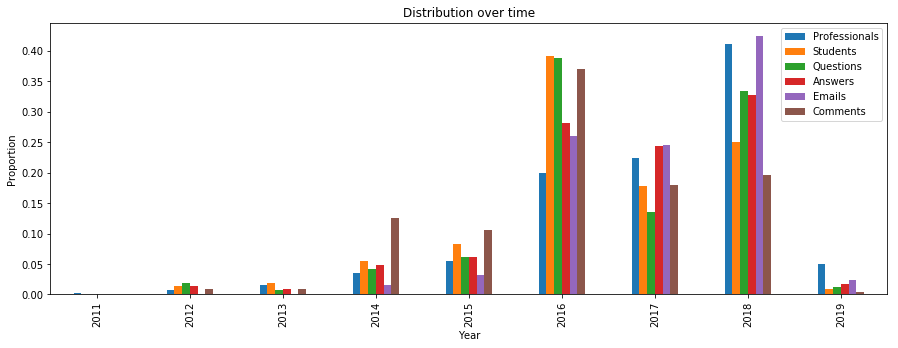

In [115]:
plt_data=pd.DataFrame({
        'Professionals':plt_professionals,
        'Students':plt_students,
        'Questions': plt_questions, 
        'Answers': plt_answers,
        'Emails': plt_emails,
        'Comments': plt_comments
    })
plt_data.plot(kind='bar', figsize=(15,5))
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.title('Distribution over time')
plt.show()

### Missing values (Professionals)

The *location*, *industry* and *Headline* were specified by the most professionals. Even hastags are used by most. The specification of school is made however only by the fewest.The industry could be therefore be a good feature of recommendation. Especially for new authors who have not written any answer or comments. If a professional is in the medical field, he should not necessary to get questions about a career as a lawyers.

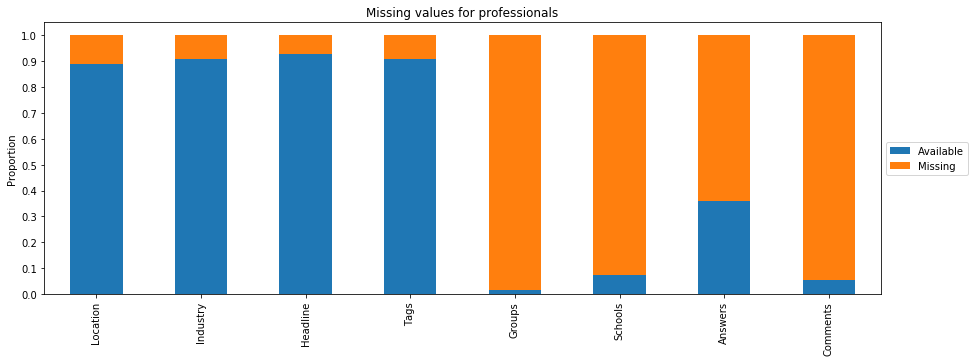

,Available,Missing
Location,0.889955,0.110045
Industry,0.908497,0.091503
Headline,0.926577,0.073423
Tags,0.909136,0.090864
Groups,0.017477,0.982523
Schools,0.075341,0.924659
Answers,0.357594,0.642406
Comments,0.052359,0.947641


In [169]:
plt_temp=df_professionals[['professionals_location','professionals_industry','professionals_headline']].fillna('Missing')
plt_temp=plt_temp.applymap(lambda x:x if x=='Missing' else 'Available')
plt_professional_industry=plt_temp.groupby('professionals_industry').size()/len(df_temp.index)
plt_professional_location=plt_temp.groupby('professionals_location').size()/len(df_temp.index)
plt_professional_headline=plt_temp.groupby('professionals_headline').size()/len(df_temp.index)

plt_professionals_tags=df_tag_users['tag_users_user_id'].unique() # Unique User List
plt_professionals_tags=df_professionals.professionals_id.apply(lambda x : 'Available' if x in plt_professionals_tags else 'Missing').rename('professionals_tags')
plt_professionals_tags=plt_professionals_tags.groupby(plt_professionals_tags).size()/len(plt_professionals_tags.index)


plt_professionals_group=df_group_memberships['group_memberships_user_id'].unique() # Unique User List
plt_professionals_group=df_professionals.professionals_id.apply(lambda x : 'Available' if x in plt_professionals_group else 'Missing').rename('professionals_group')
plt_professionals_group=plt_professionals_group.groupby(plt_professionals_group).size()/len(plt_professionals_group.index)


plt_professionals_school=df_school_memberships['school_memberships_user_id'].unique() # Unique User List
plt_professionals_school=df_professionals.professionals_id.apply(lambda x : 'Available' if x in plt_professionals_school else 'Missing').rename('professionals_school')
plt_professionals_school=plt_professionals_school.groupby(plt_professionals_school).size()/len(plt_professionals_school.index)

plt_temp=df_professionals[['professionals_answers_count', 'professionals_comments_count']]
plt_temp=plt_temp.applymap(lambda x : 'Available' if x>0 else 'Missing')

plt_professionals_answers=plt_temp.groupby('professionals_answers_count').size()/len(plt_temp.index)
plt_professionals_comments=plt_temp.groupby('professionals_comments_count').size()/len(plt_temp.index)

plt_data = pd.DataFrame({'Location': plt_professionals_location,
                        'Industry': plt_professionals_industry,
                        'Headline': plt_professionals_headline,
                        'Tags': plt_professionals_tags,
                        'Groups': plt_professionals_group,
                        'Schools': plt_professionals_school,
                        'Answers': plt_professionals_answers,
                        'Comments': plt_professionals_comments,})

plt_data.T.plot(kind='bar', stacked=True, figsize=(15, 5))
plt.ylabel('Proportion')
plt.title('Missing values for professionals')
plt.yticks(np.arange(0, 1.05, 0.1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt_data.T

### Missing Values (Students)
It's a little different with the students. Only the location is specified by most students, while  the rest is rather not used.

In [24]:
%time
df_temp=df_students[['students_location']].fillna('Missing')
df_temp=df_temp.applymap(lambda x:x if x =='Missing' else 'Available')
plt_students_location=df_temp.groupby('students_location').size()/len(df_temp.index)
plt_students_tags=df_tag_users.tag_users_user_id.unique()
plt_students_tags=df_students['students_id'].apply(lambda x: 'Available' if x in plt_students_tags else 'Missing').rename('students_tags')
plt_students_tags=plt_students_tags.groupby(plt_students_tags).size()/len(plt_students_tags.index)

plt_students_group=df_group_memberships.group_memberships_user_id.unique()
plt_students_group=df_students.students_id.apply(lambda  x: 'Available' if x in plt_students_group else 'Missing' ).rename('students_groups')
plt_students_group=plt_students_group.groupby(plt_students_group).size()/len(plt_students_group.index)

plt_students_school = df_school_memberships.school_memberships_user_id.unique()
plt_students_school = df_students['students_id'].apply(lambda x: 'Available' if x in plt_students_school else 'Missing').rename('students_schools')
plt_students_school = plt_students_school.groupby(plt_students_school).size()/len(plt_students_school.index)

df_temp=df_students[['students_questions_count','students_comments_count']]
df_temp=df_temp.applymap(lambda x:  'Available' if x >0 else 'Missing')
plt_students_questions = df_temp.groupby('students_questions_count').size()/len(df_temp.index)
plt_students_comments = df_temp.groupby('students_comments_count').size()/len(df_temp.index)

plt_students_data = pd.DataFrame({'Location': plt_students_location,
                        'Tags': plt_students_tags,
                        'Groups': plt_students_group,
                        'Schools': plt_students_school,
                        'Answers': plt_students_questions,
                        'Comments': plt_students_comments,})

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.78 µs


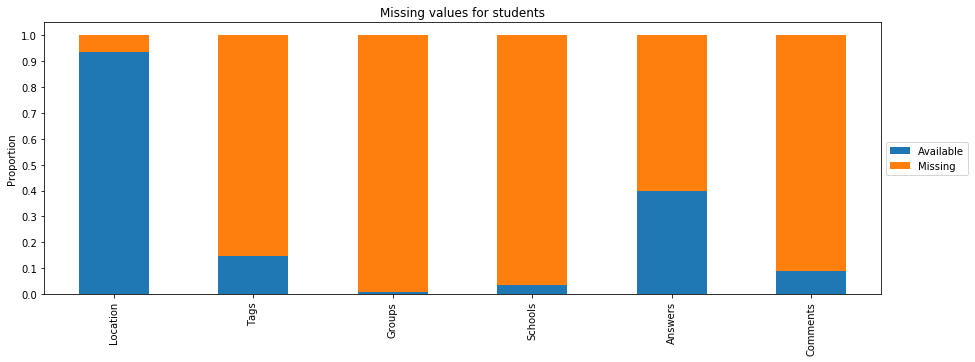

,Available,Missing
Location,0.934358,0.065642
Tags,0.148784,0.851216
Groups,0.007588,0.992412
Schools,0.034226,0.965774
Answers,0.397275,0.602725
Comments,0.087921,0.912079


In [25]:
plt_students_data.T.plot(kind='bar', stacked=True, figsize=(15, 5))
plt.ylabel('Proportion')
plt.title('Missing values for students')
plt.yticks(np.arange(0, 1.05, 0.1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt_students_data.T

> #### Tags Matching
- The size of bubbles depends on how many students  have subscribe the tags.  The X-axis is how many professionals have subscribe the tags and the y-axis in how many questions the tag is used.
- The top tag for professionals is telecommunicaitons on the right site with about 11% but tag doesn't appear in many questions  or students subscription.
- The top tag for questions is college with 15.6% and career with 6.5%. The other top tags are career specific(medicine, Engineering, business,...)
- The Top tag for students is college  but with only 1.5% of the sutudents subscribe the tag. 

In [26]:
df_students_tags=df_tag_users[df_tag_users.tag_users_user_id.isin(df_students.students_id)]
df_students_tags= pd.merge(df_students_tags, df_tags, left_on='tag_users_tag_id', right_on='tags_tag_id')
df_students_tags['user_type'] = 'student'
df_professionals_tags=df_tag_users[df_tag_users.tag_users_user_id.isin(df_professionals.professionals_id)]
df_professionals_tags= pd.merge(df_professionals_tags, df_tags, left_on='tag_users_tag_id', right_on='tags_tag_id')
df_professionals_tags['user_type'] = 'professional'

df_questions_tags=df_tag_questions
df_questions_tags = pd.merge(df_questions_tags, df_tags, left_on='tag_questions_tag_id', right_on='tags_tag_id')
df_questions_tags['user_type'] = 'question'
plt_data =pd.concat([df_students_tags, df_professionals_tags, df_questions_tags])

In [27]:
df_students_tags.shape, df_professionals_tags.shape, df_questions_tags.shape, 

((19205, 5), (117458, 5), (76553, 5))

In [28]:
# plt_data =plt_data [['tags_tag_name','user_type']].pivot_table(index='tags_tag_name', columns='user_type',aggfunc=len, fill_value=0)
# plt_data ['professional'] = df_tags_data['professional'] / df_professionals.shape[0]
# plt_data ['student'] = plt_data ['student'] / df_students.shape[0]
# plt_data ['question'] = plt_data ['question'] / df_questions.shape[0]
# plt_data['sum'] = (plt_data['professional'] + plt_data['student'] + plt_data['question'])
# # plt_data = plt_data.sort_values(by='sum', ascending=False).drop(['sum'], axis=1).head(100)
# plt_data=plt_data.sort_values(by='sum', ascending=False).drop(['sum'], axis=1).head(100)

AttributeError: 'DataFrame' object has no attribute 'professional'

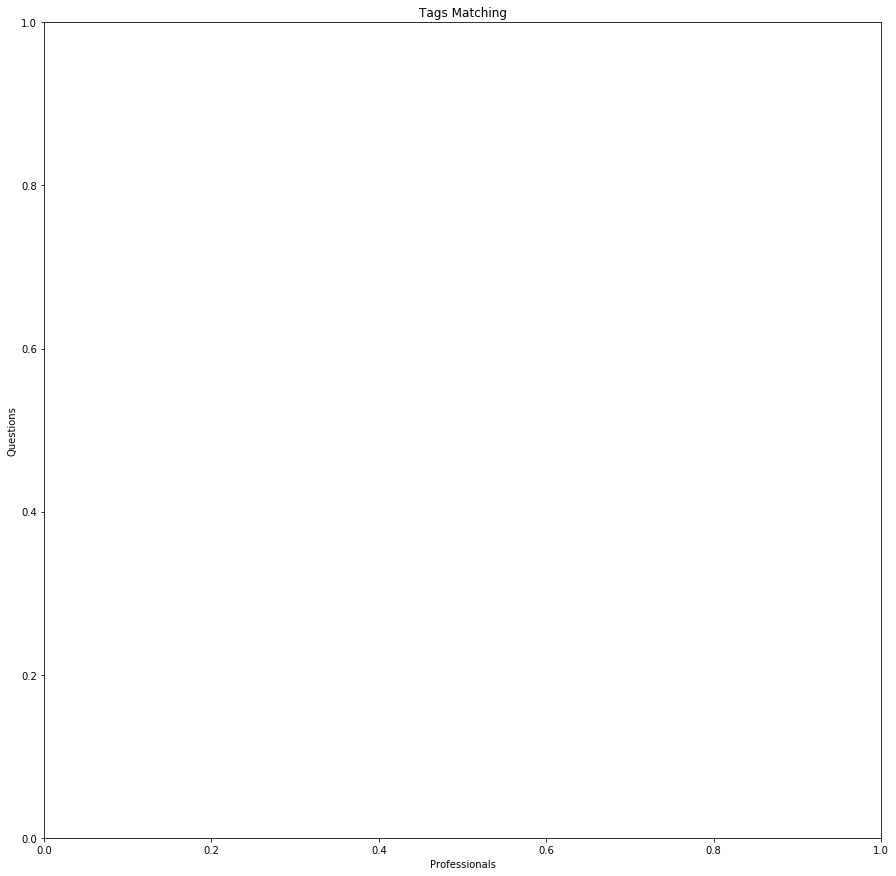

In [29]:
# plt_data
# Bubble sort
fig, ax = plt.subplots(facecolor='w',figsize=(15, 15))
ax.set_xlabel('Professionals')
ax.set_ylabel('Questions')
ax.set_title('Tags Matching')
ax.set_xlim([0, max(plt_data.professional)+0.001])
ax.set_ylim([0, max(plt_data.question)+0.005])
import matplotlib.ticker as mtick
ax.xaxis.set_major_formatter(mtick.FuncFormatter("{:.2%}".format))
ax.yaxis.set_major_formatter(mtick.FuncFormatter("{:.2%}".format))
ax.grid(True)
i =0
for key, row in plt_data.iterrows():
    ax.scatter(row.professional, row.question, s=10+row.student*10**5, alpha=0.5)
    if i >25:
        ax.annotate('{}: {:.2%}'.format(key, row['student']), xy=(row['professional'], row['question']))
    i += 1
plt.show()

In [ ]:
# WordCloud
plt.figure(figsize=(20, 20))
wordcloud_values=['student', 'professional', 'question']
axisNum = 1
for wordcloud_value in wordcloud_values:
    wordcloud=WordCloud(margin=0, max_words=20,random_state=41).generate_from_frequencies(plt_data[wordcloud_value])
    ax=plt.subplot(1,3,axisNum)
    plt.imshow(wordcloud)
    plt.title(wordcloud_value)
    plt.axis("off")
    axisNum+=1
plt.show()

### First Activity After Registration
Here we will see how long it took, That a professional makes his first answer or a student his first question after registration to portal. Most of them write the first answer or question in the first day or haven't written yet and used their account for other activites. 

In [ ]:
df_plt_professionals=df_professionals
df_plt_professionals=df_plt_professionals[(df_plt_professionals.professionals_date_joined >= '01-01-2016') & (df_plt_professionals.professionals_date_joined <= '30-06-2018')]
df_plt_professionals=(df_plt_professionals.date_first_activity -df_plt_professionals.professionals_date_joined).dt.days.fillna(9999).astype(int)
df_plt_professionals=df_plt_professionals.groupby(df_plt_professionals).size()/len(df_plt_professionals)
df_plt_professionals=df_plt_professionals.rename(lambda x:0  if x <0.0 else x)
df_plt_professionals=df_plt_professionals.rename(lambda  x:0  if x <=7.0 or  x==9999 else '>7')
df_plt_professionals=df_plt_professionals.rename({9999:'NaN'})
plt_professionals =df_plt_professionals.groupby(level=0).sumx

In [ ]:
plt_students =df_students
plt_students = plt_students[(plt_students['students_date_joined'] >= '01-01-2016') & (plt_students['students_date_joined'] <= '30-06-2018')]
plt_students = (plt_students['date_first_activity'] - plt_students['students_date_joined']).dt.days.fillna(9999).astype(int)
plt_students = plt_students.groupby(plt_students).size()/len(plt_students.index)
plt_students = plt_students.rename(lambda x: 0 if x < 0.0 else x)
plt_students = plt_students.rename(lambda x: x if x <= 7.0 or x == 9999 else '> 7')
plt_students = plt_students.rename({9999:'NaN'})
plt_students = plt_students.groupby(level=0).sum()

plt_data = pd.DataFrame({'Professionals': plt_professionals,
                        'Students': plt_students})

plt_data.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Days')
plt.ylabel('Proportion')
plt.title('Days for first activity after registration')
plt.show()

### Last Activity After Registration

Depending on the last comment, question or answer of a user, We have extract the last activity date. On the previously plot we have seen, that many users haven't done  any activity yet. For the **'Last Activity'** plot, we take a look only on users with alreday have one activity(dropna).

On the cumulative histogram, we see that in the last 12 months only 39% of professionls and 24% oif students have written a comment. questions or anwer.

50% professional haven't done any activity for 17 monthns.

In [ ]:
df_plt_professionals=((actual_date-df_professionals.))


# Topic Model (Linear Discriminant Analysis(LDA))
In this section, I will implement a LDA model to get topoic probabilities fo questions. We can use this to see how topics are distributed across  questions  and which word characterize them

New Question can be allocated to topic  and farwarded to the professional who are familiar with these topics.
    1. Use NLP on the questions corpus
        * use part-of-speech tagging to filter word
        * Filter Exterm values of corpus.
        * Calculate the TF-IDF
    2. Train a LDA model
    3. Give the topics names
    4. Get the topic probability of a query text.

In [ ]:
# Gensim Dictionary
extremes_no_below=10
extremes_no_above=0.6
extremes_keep_n=8000

In [ ]:
# Linear Discriminant Analysis
num_topics=18
passes=20
chuncksize=1000
alpha=1/50

In [ ]:
def get_model_results(ldamodel, corpus, dictonary):
    """ Create doc-topic probabilities  table and visualization for the LDA modle """
    vis=pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sorted=False)
    transformed=ldamodel.get_model_results(corpus)
    df=pd.DataFrame.from_records([{v:k} for v , k in rows for row in transformed])
    return vis, df

In [ ]:
def get_model_wordCloud(ldamodel):
    """ Create  a Word Cloud  for each topic of the LDA model"""
    plot_cols=3
    plots_rows=math.ceil(num_topics/3)
    axisNum=0
    plt.figureg(figsize=(5*plot_cols, 3*plot_rows))
    for topicID in range(ldamodel.state.get_lambda().shape[0]):
        #Gether most relevent term for the given topic
        topics_terms=ldamodel.state.get_lambda()
        tempDict={}
        for i in range(1, len(topics_terms[0])):
            tempDict[ldamodel.id2word[i]]= topics_terms[topicID,i]
            
        #draw the wordcloud
        wordcloud=WordCloud(margin=0,max_words=0).generate_from_frequencies(tmpDict)
        axisNum  +=1
        ax=plt.subplot(plot_rows, plot_cols, axisNum)
        
        plt.imshow(wordcloud, interpolation='bilinear')
        title=topicID
        plt.title(title)
        plt.axis("off")
        plt.margins(x=0,y=0)
    plt.show()
        

In [ ]:
def  topic_query(data, query ):
    """ Get Documents matching the query with  the doc-topic probabilities"""
    result=data
    result["sort"]=0
    for topic in query:
        result=result[result[topic] >=query[topic]]
        result['sort']+=result[topic]
    result = result.sort_values(['sort'], ascending=False)
    result = result.drop('sort', axis=1)
    result = result.head(5)
    return result

### Design ML Model

In [ ]:
%time
lda_tokens=df_questions.nlp_tokens
# gensim dictionary

lda_dict=gensim.corpora.Dictionary(lda_tokens)
print(len(lda_dict))
lda_dict.filter_extremes(no_above=extremes_no_above, no_below=extremes_no_below, keep_n=extremes_keep_n)
print(len(lda_dict))
lda_corpus=[lda_dict.doc2bow(doc) for doc in lda_tokens]
lda_tfidf=gensim.models.TfidfModel(lda_corpus)
lda_corpus=lda_tfidf[lda_corpus]

lda_model=gensim.models.LdaModel(lda_corpus,num_topics=num_topics, id2word=lda_dict, passes=passes, update_every=0, chunksize=chuncksize, alpha=alpha,random_state=41)

# Create visualization and Doc-Topic Probabilities



### Recommendation Engine
The Recommendation engine should help to answer the following questions.
*     **When a student asked a questions. are there already any similar questions that might help him?**       
       - When a student ask a a question, there may already be similar questions. This could help him with his own questions.
*     **Which professionals are most expected to answer the new question?**      
      - New Question should be answered quikly. For this reason, it should be forwared to  professional, who can answer the question best.
*     **Which Question should be forwarded  to a professional to answer?**
       - The previous point was from the prespective of a new questions. Here the professional is the focus.Every professional should  be desplayed questions.which could be possible for him to answer (e.g. home screen or daily/weekly e-mail).
*     **Which hastags might intrested a user because of his previous activties?**
       - The last point is to recommend hashtags to a user that might be of interest to him.



### Get Similar Questions
